# Disease Type Classifier
- BME 230A class project winter 2019
- Andrew E. Davidson
- [aedavids@ucsc.edu](mailto:aedavids@edu?subject=SimpleModel.ipynb)

classify cancer type from gene expression

## Abstract

originally trainned on entire data set, tumor and normal. 

training accuracy : 0.98

training accuracy : 0.93

turns out the normal case are marked as having a sort of diseases. I removed the normal cases

see diseaseTypeClassifierEval.ipynb

In [1]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger
from keras.layers import Dense
from keras.layers import Dense,Input,BatchNormalization, InputLayer, Activation
from keras.models import Sequential
from keras.optimizers import Adam, SGD, Adadelta, Adagrad
from keras.regularizers import L1L2
from keras.utils import np_utils

import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import sys

import tensorflow as tf

# fix random seed for reproducibility
theMeaningOfLife = 42

import keras
if "2.1.6" != keras.__version__ :
    emsg = "ERROR keras version {} != 2.1.6, new version can not save and restore models".format(keras.__version__)
    raise ValueError(emsg)

# add path to our local modules
# assume they are in the same directory we launched the juypter server in
# /home/ubuntu/BME-230a
!pwd
localModuleDir = "."
sys.path.append(localModuleDir)
from loadData import loadTumorNormalData

Using TensorFlow backend.


/home/ubuntu/BME-230a


## Load data and Explore

In [2]:
rootDir = "/bme-230a-ebs"
sourceDataFilePath = "{}/data/tcga_target_gtex.h5".format(rootDir)
print(sourceDataFilePath)
if not os.path.isfile(sourceDataFilePath) :
    emsg = "ERROR: {} not found".format(sourceDataFilePath)
    print(emsg)
    print("change rootDir")
    sys.stdout.flush() # force error message to print
    raise ValueError(emsg)

/bme-230a-ebs/data/tcga_target_gtex.h5


In [3]:
%%time
# Load training set
XDF = pd.read_hdf(sourceDataFilePath, "expression")
print("XDF.shape:{}".format(XDF.shape))

yDF = pd.read_hdf(sourceDataFilePath, "labels")
print("yDF.shape:{} type(yDF):".format(yDF.shape)) 

XDF.shape:(19126, 58581)
yDF.shape:(19126, 7) type(yDF):
CPU times: user 144 ms, sys: 3.01 s, total: 3.16 s
Wall time: 3.15 s


In [4]:
XDF.head(1)

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,-9.966041,-9.965816,-9.965881,4.4595,0.9343,-5.0116,7.5126,0.8164,-2.114,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,5.326995,-9.9658


In [5]:
yDF.head(1)

,category,disease,primary_site,sample_type,gender,study,tumor_normal
id,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal


In [6]:
print(yDF.columns)

Index(['category', 'disease', 'primary_site', 'sample_type', 'gender', 'study',
       'tumor_normal'],
      dtype='object')


In [7]:
print('\n"disease" and "category" are identical')
np.array_equal(pd.unique( yDF.loc[:,"disease"] ), pd.unique( yDF.loc[:,"category"] ))


"disease" and "category" are identical


True

In [8]:
# make sure we remove normal cases from our data set. the disease values do not
# make sence
yNormalRows = yDF['tumor_normal'] == 'Normal'        
yNormalDF = yDF.loc[yNormalRows, ['disease', 'tumor_normal']]

print("\nY: normalDF.shape: {}".format(yNormalDF.shape))
print("Y: normal case unique disease types count: {}"
      .format( pd.unique(yNormalDF.loc[:,"disease"]).shape ))

yNormalDF.head()


Y: normalDF.shape: (8596, 2)
Y: normal case unique disease types count: (80,)


,disease,tumor_normal
id,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Normal
GTEX-1117F-0426-SM-5EGHI,Muscle - Skeletal,Normal
GTEX-1117F-0526-SM-5EGHJ,Artery - Tibial,Normal
GTEX-1117F-0626-SM-5N9CS,Artery - Coronary,Normal
GTEX-1117F-0726-SM-5GIEN,Heart - Atrial Appendage,Normal


In [9]:
yTumorRows = yDF['tumor_normal'] != 'Normal'        
yTumorDF = yDF.loc[yTumorRows, ['disease', 'tumor_normal']]

print("\nY: tumorDF.shape:{}".format(yTumorDF.shape))
print("Y: tumor case unique disease types count: {}"
      .format( pd.unique(yTumorDF.loc[:,"disease"]).shape ))

yTumorDF.head()


Y: tumorDF.shape:(10530, 2)
Y: tumor case unique disease types count: (38,)


,disease,tumor_normal
id,,
TARGET-10-PAKSWW-03,Acute Lymphoblastic Leukemia,Tumor
TARGET-10-PAMXHJ-09,Acute Lymphoblastic Leukemia,Tumor
TARGET-10-PAMXSP-09,Acute Lymphoblastic Leukemia,Tumor
TARGET-10-PANCVR-03,Acute Lymphoblastic Leukemia,Tumor
TARGET-10-PANCVR-04,Acute Lymphoblastic Leukemia,Tumor


In [10]:
# diseaseClasses = pd.unique( yDF.loc[:,"disease"] )
# diseaseK = len(diseaseClasses)
# print("diseaseK: {}, type(diseaseClasses): {}".format(diseaseK, type(diseaseClasses)))
# print(diseaseClasses)
print("tumor disease types:{}".format(pd.unique(yTumorDF.loc[:,"disease"])))

tumor disease types:['Acute Lymphoblastic Leukemia' 'Acute Myeloid Leukemia'
 'Acute Myeloid Leukemia, Induction Failure Subproject' 'Neuroblastoma'
 'Wilms Tumor' 'Clear Cell Sarcoma Of The Kidney'
 'Glioblastoma Multiforme' 'Ovarian Serous Cystadenocarcinoma'
 'Lung Adenocarcinoma' 'Lung Squamous Cell Carcinoma'
 'Prostate Adenocarcinoma' 'Uterine Corpus Endometrioid Carcinoma'
 'Bladder Urothelial Carcinoma' 'Testicular Germ Cell Tumor'
 'Esophageal Carcinoma' 'Pancreatic Adenocarcinoma'
 'Kidney Papillary Cell Carcinoma' 'Liver Hepatocellular Carcinoma'
 'Cervical & Endocervical Cancer' 'Sarcoma' 'Breast Invasive Carcinoma'
 'Thymoma' 'Mesothelioma' 'Colon Adenocarcinoma' 'Stomach Adenocarcinoma'
 'Skin Cutaneous Melanoma' 'Cholangiocarcinoma'
 'Kidney Clear Cell Carcinoma' 'Thyroid Carcinoma'
 'Head & Neck Squamous Cell Carcinoma' 'Rectum Adenocarcinoma'
 'Brain Lower Grade Glioma' 'Diffuse Large B-Cell Lymphoma'
 'Kidney Chromophobe' 'Uterine Carcinosarcoma' 'Adrenocortical Cance

Text(0.5,1,'Fig 1. Tumor Case Counts')

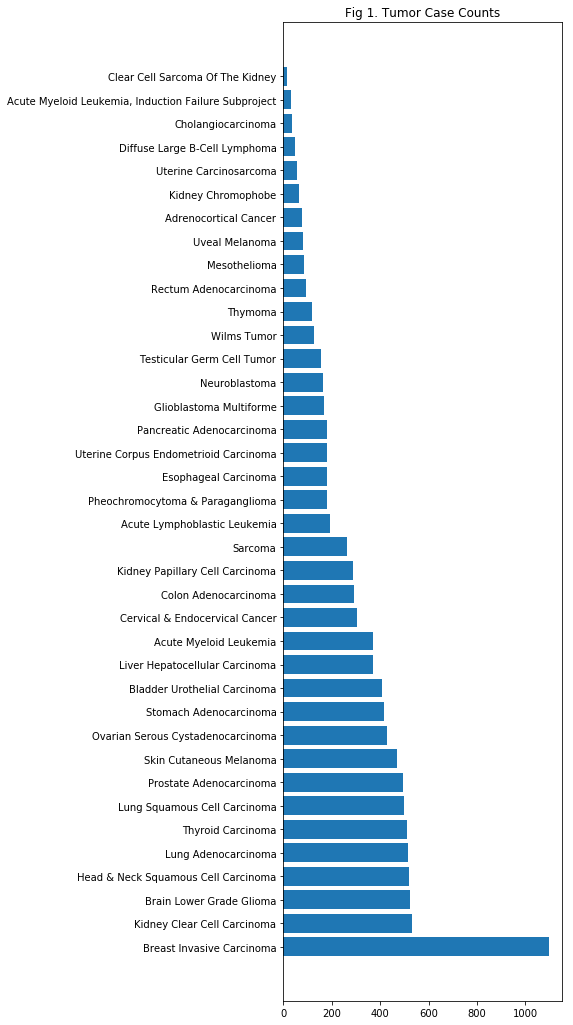

In [11]:
def plotCategoryCounts(df, colNameStr, ):
    '''
    TODO: make this more generic
    argument 
        df: a pandas data frame 
        colNameStr: 
        
    returns 
        (fig, ax)
    '''
    # countDF is series
    countDF = df[colNameStr].value_counts()
    fig, ax = plt.subplots()
    fig.set_size_inches(5,18)
    ax.barh(countDF.index, countDF)    
    
    return (fig, ax)

fig, ax = plotCategoryCounts(yTumorDF, "disease")
ax.set_title("Fig 1. Tumor Case Counts")

## Prepare data

TODO simple classifier on 93 classes -> Trainable params: 5,565,288 and takes 9min 26s to train. Try select most frequent classes

### remove sample with missing data

In [12]:
# https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/
yNumMissingValues = yTumorDF.isnull().sum().sum()
print("number of missing values from y:{}".format(yNumMissingValues))

yTumorDF = yDF[yTumorRows]
yDF = yTumorDF
yTumorDF = None # free memory
print("yDF.shape:{}".format(yDF.shape))

number of missing values from y:0
yDF.shape:(10530, 7)


In [13]:
XTumorDF = XDF[yTumorRows]
XDF = XTumorDF

XDFNumMissingValues = XDF.isnull().sum().sum()
print("number of missing values from X:{}".format(XDFNumMissingValues))

#XTumorDF = None # free memory
print("XDF.shape:()".format(XDF.shape))

number of missing values from X:0
XDF.shape:()


In [19]:
# Convert disease  into numerical values 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

# use diseaseLabelEncoder.inverse_transform(yDF["disease_value"]) to get labels as string back
diseaseLabelEncoder = LabelEncoder()
yDF["disease_value"] = pd.Series(diseaseLabelEncoder.fit_transform(yDF["disease"]), 
                                 index=yDF.index)

In [20]:
# create one hot encodings

oneHots = np_utils.to_categorical(yDF["disease_value"])
print(type(oneHots))
print(oneHots.shape)

diseaseValues = yDF["disease_value"].values.reshape(yDF.shape[0],-1)
print(type(diseaseValues))
print(diseaseValues.shape)

yOneHots = np.append(diseaseValues, oneHots, axis=1)
print("type(yOneHots):{}".format(type(yOneHots)))
print("yOneHots.shape:{}".format(yOneHots.shape))

<class 'numpy.ndarray'>
(10530, 38)
<class 'numpy.ndarray'>
(10530, 1)
type(yOneHots):<class 'numpy.ndarray'>
yOneHots.shape:(10530, 39)


In [21]:
%%time
# Split into stratified training and test sets based on classes (i.e. 
# disease type) so that we have equal proportions of each disease type 
# in the train and test sets
  
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, 
                               random_state=theMeaningOfLife)
for train_index, test_index in split.split(XDF.values, 
                                           yDF["disease_value"]):
    XTrainNumpy = XDF.values[train_index]
    XTestNumpy  =  XDF.values[test_index]
    yTrainNumpy = yOneHots[train_index]
    yTestNumpy  = yOneHots[test_index]
    
print("XTrainNumpy.shape: {} XTestNumpy.shape: {}"
      .format(XTrainNumpy.shape, XTestNumpy.shape))

# pandas series values attribute create numpy arrays with shapes that
# are under specified. E.G. yTestNumpy.shape: (3826,). this causes a lot
# of bugs in other packages reshape(n,-1) causes reshape to set the last
# value
yTrainNumpy = np.reshape(yTrainNumpy,(yTrainNumpy.shape[0], -1))
yTestNumpy  = np.reshape( yTestNumpy, (yTestNumpy.shape[0], -1))

print("yTrainNumpy.shape: {} yTestNumpy.shape: {}"
      .format(yTrainNumpy.shape, yTestNumpy.shape))
print(type(yTestNumpy))

XTrainNumpy.shape: (8424, 58581) XTestNumpy.shape: (2106, 58581)
yTrainNumpy.shape: (8424, 39) yTestNumpy.shape: (2106, 39)
<class 'numpy.ndarray'>
CPU times: user 552 ms, sys: 936 ms, total: 1.49 s
Wall time: 1.49 s


In [22]:
yTrainNumpy[0:2]
# xxx = yTrainNumpy[:,1:]
# xxx[0:2]

array([[20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

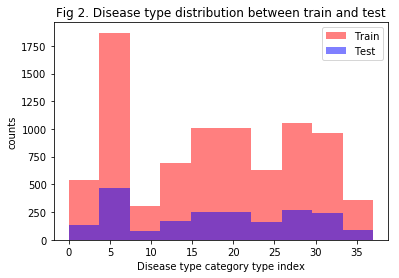

In [26]:
# check class sizes
# [:.0] is disease_value column
plt.hist(yTrainNumpy[:,0], alpha=0.5, label='Train', color="red")
plt.hist(yTestNumpy[:,0],   alpha=0.5, label='Test', color="blue")
plt.legend(loc='upper right')
plt.title("Fig 2. Disease type distribution between train and test")
plt.ylabel("counts")
plt.xlabel("Disease type category type index")
plt.show()

## Create  and train model

In [27]:
def multiClassClassifier(inputDim=None, outputDim=None, learningRate=0.001):
    '''
    constructs a multi classifier model that includes a batch normalization
    preprocess step. normalizaton typically reduces training time.
    
    arguments:
        inputDim: 
            type int: the number of features in each sample
        
        outputDim: 
            type int the number of classes
        
        learningRate: 
            type float: scaling factor for adjusting weight. larger
            values may train faster how ever can cause optimization 
            algorithm to diverge if to large. Use loss curver plot
            to evaluate
            
    return:
        keras.models
    '''
    classify = [
        InputLayer(input_shape=(inputDim,)),
        # TODO: Is Keras smart? only need to run preprocessing step
        # once        
        BatchNormalization(),
        Dense(outputDim), # dot(input, kernel) + bias
        Activation('softmax') 
    ]
    
    model = Sequential(classify)   
    # https://keras.io/backend/#categorical_crossentropy
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=learningRate), metrics=['accuracy']) 
    
    return model 

In [28]:
%%time
# train model

modelName="diseaseClassifier"
# the first col of yTrainNumpy is the disease value. 
# numCases is size prediction output
numCases = yTrainNumpy.shape[1] -1

diseaseClassifierModel = multiClassClassifier(
                                inputDim=XTrainNumpy.shape[1],
                                outputDim=numCases,
                                )
diseaseClassifierModel.summary()

# https://keras.io/callbacks/
checkPointPath="./models/{}.chkPt".format(modelName)
callbacks = [
    # monitor valuse either 'acc' for accuracy or 'loss'
    # 'val_loss' is loss on hold if valaidation_split is set
    # 'loss' is loss on training
    # same for 'acc' and 'val_acc'
    EarlyStopping(monitor='loss', patience=2, verbose=0) 
    ,ModelCheckpoint(checkPointPath, monitor='loss', save_best_only=False, verbose=0)
    # FIXME: progbar generates run time error
    #,ProgbarLogger(count_mode='samples', stateful_metrics=None)
]

trainOneHots = yTrainNumpy[:,1:]
history = diseaseClassifierModel.fit(XTrainNumpy,trainOneHots,        
                                        shuffle=None, # we already shuffled
                                        epochs= 8, #20, #100
                                        batch_size=1024, 
                                        # we already split the data         
                                        validation_split=0.0, 
                                        verbose=0,
                                        callbacks=callbacks
                                     )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 58581)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 58581)             234324    
_________________________________________________________________
dense_1 (Dense)              (None, 38)                2226116   
_________________________________________________________________
activation_1 (Activation)    (None, 38)                0         
Total params: 2,460,440
Trainable params: 2,343,278
Non-trainable params: 117,162
_________________________________________________________________
CPU times: user 1min 49s, sys: 11.3 s, total: 2min
Wall time: 37.2 s


In [29]:
def calculateAccuracy(model, X, y):
    '''
    calculates accuracy

    arguments
        model: 
            a keras model that returns the output of softmax
        
        X:
            the set of data to make prediction on. Types must be numpy array
        y:
            the expected values, a numpy array with shape (n, 1) of values. Do not pass one hots
    
    returns float
    '''
    # predictions is output of softmax layer
    predictions = model.predict(X)
    predictedValuesTensor = keras.backend.argmax(predictions)
    
    # use keras escape hatch to tensor flow
    sess = tf.Session()
    with sess.as_default():
        predictedValuesNumpy = predictedValuesTensor.eval()

    indicators = np.equal(predictedValuesNumpy, y)
    accuracy = np.sum(indicators) / len(indicators)
    
    return accuracy

In [32]:
%%time
trainAcc = calculateAccuracy( diseaseClassifierModel, 
                             XTrainNumpy, 
                             yTrainNumpy[:,0] )

testAcc  = calculateAccuracy( diseaseClassifierModel,
                             XTestNumpy,   
                             yTestNumpy[:,0] )

print("training accuracy:{}".format(trainAcc))
print("    test accuracy:{}".format(testAcc))

training accuracy:0.9937084520417854
    test accuracy:0.9577397910731245
CPU times: user 15.9 s, sys: 1.63 s, total: 17.5 s
Wall time: 4.38 s


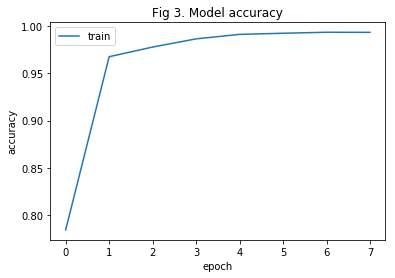

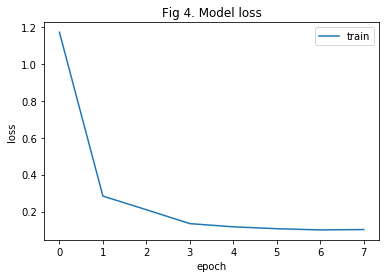

In [34]:
# summarize history for accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('Fig 3. Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# # summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Fig 4. Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [35]:
# save model
modelRootDir = "{}/models".format(rootDir)
fullModelPath = "{}/{}.h5".format(modelRootDir, modelName)

if not os.path.exists(modelRootDir):
    print("create modle directory:{}".format(modelRootDir))
    os.makedirs(modelRootDir)

if not os.path.isfile(fullModelPath):
    diseaseClassifierModel.save(fullModelPath)
    print("Saved {} to disk".format(fullModelPath))
else:
    print("ERROR: model was not save. files already exist {}".format(fullModelPath))

ERROR: model was not save. files already exist /bme-230a-ebs/models/diseaseClassifier.h5
